# **About the dataset[<a href="https://www.kaggle.com/tongpython/cat-and-dog">src</a>]**
## **Description**

This dataset is for running the code from this site: https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8. Our task is to train a model which could successfully classify images between dogs and cat.

# **Steps Involved**
1. Getting familier with dataset
2. Data Visualization
3. Data Preparation
4. Building and training the model
5. Model Evaluation
6. Performing prediction on unseen data
7. Miscellaneous

ref : https://www.kaggle.com/angqx95/feature-extractor-fine-tuning-with-keras

# **1. Reading and  getting familier with dataset**

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
%matplotlib inline

#pd.set_option("display.max_rows", None,"display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

def path_extractor(zipPATH,zip_file,trgt_dir):
  # Extracting content, if "trgt_dir" not present
  if trgt_dir not in os.listdir('.'):
    with zipfile.ZipFile(zipPATH+zip_file,"r") as z:
            print(f"Extracting content from {zip_file} ......")
            z.extractall()
            print(f"Extracted to {os.getcwd()}")
  # Storing paths of images in "trgt_dir" to a list
  paths = []
  print(f"Reading image paths in {trgt_dir} directory")
  for root, dirs, files in os.walk("."+os.path.sep+trgt_dir):
      for file in files:
        if file.endswith(".jpg"):
          paths.append(os.path.join(root, file))
  print("DONE")
  return paths

In [4]:
# Location of zipfile containing dataset
PATH = "/content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/dataset/"
zip_file = "archive.zip"

trainImg_paths = path_extractor(PATH,zip_file,trgt_dir="training_set")
testImg_paths = path_extractor(PATH,zip_file,trgt_dir="test_set")

Reading image paths in training_set directory
DONE
Reading image paths in test_set directory
DONE


In [5]:
trainImg_paths[:3]

['./training_set/training_set/cats/cat.1455.jpg',
 './training_set/training_set/cats/cat.454.jpg',
 './training_set/training_set/cats/cat.3184.jpg']

In [6]:
# Obtaining class name from Image Path
trainImg_paths[0].split(os.path.sep)[-2]

'cats'

In [7]:
import cv2

IMAGE_SIZE = (224,224)

def images_extractor(paths):
  images = []
  classNo = []
  for path in paths:
    currImg_BGR = cv2.imread(path)
    b,g,r = cv2.split(currImg_BGR)
    currImg_RGB = cv2.merge([r,g,b])
    currImg = cv2.resize(currImg_RGB,IMAGE_SIZE)
    images.append(currImg)
    classNo.append(path.split(os.path.sep)[-2])
  return images,classNo

In [8]:
X_train , y_train = images_extractor(trainImg_paths)
X_train = np.array(X_train)
y_train = np.array(y_train)
print("Shape of train set",X_train.shape)
print("Number of train samples",len(X_train))

Shape of train set (8005, 224, 224, 3)
Number of train samples 8005


In [9]:
X_test , y_test = images_extractor(testImg_paths)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Shape of test set",X_test.shape)
print("Number of test samples",len(X_test))

Shape of test set (2023, 224, 224, 3)
Number of test samples 2023


# **2. Data Visualization**

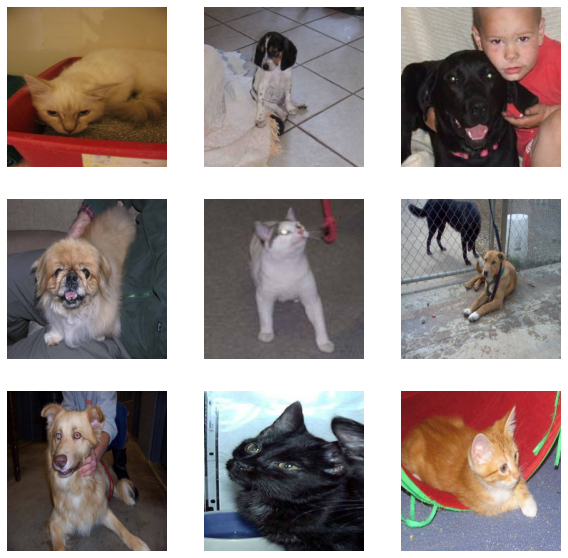

In [22]:
# Visualizing 9 random images
plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(3,3,i)
  random_num = np.random.randint(0,len(X_train))
  plt.imshow(X_train[random_num][:,:,:])
  plt.grid(False)
  plt.axis('off')

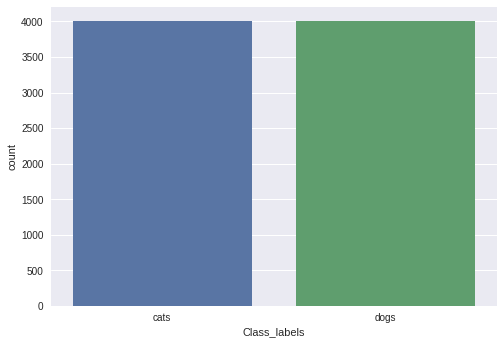

In [23]:
# Checking distribution of classes in train set
y_train_df = pd.DataFrame(y_train,columns=["Class_labels"])
sns.countplot(x='Class_labels',data=y_train_df)

# **3. Data Preparation**

In [10]:
seed = 100
np.random.seed(seed)

## **a) Separating data for validation set**

In [11]:
from sklearn.model_selection import train_test_split

valRatio = 0.1
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=valRatio, random_state=seed)
print("Shape of train set",X_train.shape)
print("Shape of validation set",X_validation.shape)
print("Shape of test set",X_test.shape)

Shape of train set (7204, 224, 224, 3)
Shape of validation set (801, 224, 224, 3)
Shape of test set (2023, 224, 224, 3)


## **b) Data Augmentation**

- Reference : https://keras.io/api/preprocessing/image/#imagedatagenerator-class
- Additional reading: https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
- Predict Generator: https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

# Train Datagenerator
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Validation Datagenerator
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Test Datagenerator
test_datagen = ImageDataGenerator(rescale = 1./255)

Using TensorFlow backend.


## **c) Encoding Output Labels**

In [13]:
y_train[:5]

array(['dogs', 'cats', 'dogs', 'cats', 'cats'], dtype='<U4')

In [14]:
y_train = pd.get_dummies(y_train).values
y_validation = pd.get_dummies(y_validation).values
y_test = pd.get_dummies(y_test).values
y_train[:5]

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0]], dtype=uint8)

# **4) Model Building**

Transfer Learning: https://keras.io/api/applications/

## **a) Importing libraries and defining custom functions**

In [16]:
# Deep Learning Libraries
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical

In [17]:
# Parameters
input_shape = (224,224,3)
learning_rate = 0.00146
batch_size = 64
epochs = 5

In [18]:
# Custom functions
def add_top(tf_model,model_name):
  '''
  This function adds custom layer on top of Pre-trained models and performs compilation.
  '''
  models = ["vgg16","resnet50v2","mobilenet","inceptionv3"]
  print(f"Building model using {model_name} architecture ...")
  # Freezing pre-trained weights
  for layer in tf_model.layers:
      layer.trainable = False

  # Adding custom layers on top
  if model_name == models[0]:
    x = Flatten()(tf_model.output) 
    x = Dense(1000, activation='relu')(x)
    prediction = Dense(units=2, activation='softmax', name='OutputLayer')(x) 
    
  else:
    x = GlobalAveragePooling2D()(tf_model.output)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    prediction = Dense(units=2, activation='softmax', name='OutputLayer')(x)

  # Combining all layers to the final model
  final_model = Model(inputs=tf_model.input, outputs=prediction, name=model_name)

  # Model compilation
  print("Compiling model ...")
  opt = Adam(learning_rate=learning_rate)
  final_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  print("DONE")
  return final_model

def model_train(model,model_name,batch_size=64,epochs=5):
  '''
  Trains model for given number of epochs and saves its best version.
  '''
  path = f"/content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_{model_name}.h5"
  # Instantiating Callbacks
  checkpoint = ModelCheckpoint(path,
                                monitor="val_loss",
                                mode="min",
                                save_best_only = True,
                                verbose=1)
  earlystop = EarlyStopping(monitor = 'val_loss', 
                              min_delta = 0, 
                              patience = 4,
                              verbose = 1,
                              restore_best_weights = True)
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  verbose = 1,
                                  min_delta = 0.0001)
    
  callbacks = [earlystop, checkpoint, reduce_lr]

  # Initializing data generators
  train_generator = train_datagen.flow(
      x=X_train,
      y=y_train,
      batch_size=batch_size,
      shuffle=True,
      seed=seed,
  )
  validation_generator = validation_datagen.flow(
      x=X_validation, 
      y=y_validation, 
      batch_size=1
  )

  # model training
  model.fit_generator(
      generator=train_generator, steps_per_epoch=X_train.shape[0] // batch_size, epochs=epochs, verbose=1,
      validation_data=validation_generator,
      validation_steps=len(X_validation),
      callbacks = callbacks
  )
  
  print(f"Best model saved at :\n{path}")
  return model

Ref: 
- https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

## **b) Using VGG16 architecture to build model**

In [34]:
from keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
model_vgg = add_top(vgg,"vgg16")

Building model using vgg16 architecture ...
Compiling model ...
DONE


In [35]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [36]:
# Steps per epoch
X_train.shape[0]//64

112

In [37]:
model_vgg = model_train(model_vgg,"vgg16",epochs=5)

Epoch 1/5
112/112 [==============================] - 92s 817ms/step - loss: 1.3951 - accuracy: 0.8238 - val_loss: 0.0023 - val_accuracy: 0.8939

Epoch 00001: val_loss improved from inf to 0.00235, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_vgg16.h5
Epoch 2/5
112/112 [==============================] - 84s 746ms/step - loss: 0.1985 - accuracy: 0.9186 - val_loss: 5.1295e-04 - val_accuracy: 0.9164

Epoch 00002: val_loss improved from 0.00235 to 0.00051, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_vgg16.h5
Epoch 3/5
112/112 [==============================] - 84s 746ms/step - loss: 0.1671 - accuracy: 0.9318 - val_loss: 0.6035 - val_accuracy: 0.8976

Epoch 00003: val_loss did not improve from 0.00051
Epoch 4/5
112/112 [==============================] - 83s 738ms/step - loss: 0.1798 - accuracy: 0.9232 - val_loss: 4.3272e-05 - val_accuracy: 0.9164

Epoch 00004: val_loss improved from

In [ ]:
from keras.models import load_model
# Loading the best model
best_vgg16 = load_model('/content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_vgg16.h5')

## **c) Using ResNet50V2 architecture to build model**

In [57]:
from keras.applications.resnet_v2 import ResNet50V2

resnet50_v2 = ResNet50V2(input_shape=input_shape, weights='imagenet', include_top=False)
model_resnet = add_top(resnet50_v2,"resnet50v2")

94674944/94668760 [==============================] - 1s 0us/step
Building model using resnet50v2 architecture ...
Compiling model ...
DONE


In [58]:
model_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [59]:
model_resnet = model_train(model_resnet,"resnet50v2",epochs=5)

Epoch 1/5
112/112 [==============================] - 88s 790ms/step - loss: 0.2129 - accuracy: 0.9223 - val_loss: 3.7810 - val_accuracy: 0.9763

Epoch 00001: val_loss improved from inf to 3.78097, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_resnet50v2.h5
Epoch 2/5
112/112 [==============================] - 85s 755ms/step - loss: 0.1253 - accuracy: 0.9479 - val_loss: 0.0000e+00 - val_accuracy: 0.9800

Epoch 00002: val_loss improved from 3.78097 to 0.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_resnet50v2.h5
Epoch 3/5
112/112 [==============================] - 83s 745ms/step - loss: 0.1004 - accuracy: 0.9620 - val_loss: 0.0000e+00 - val_accuracy: 0.9863

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/5
112/112 [==============================] - 83s 740ms/step - loss: 0.1002 - accuracy: 0.9612 - val_loss: 0.0000e+00 - val_accuracy: 0.9813

Epoch 00004: val_loss

In [60]:
from keras.models import load_model
# Loading the best model
best_resnet50v2 = load_model('/content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_resnet50v2.h5')

## **d) Using MobileNet architecture to build model**

In [63]:
from keras.applications import MobileNetV2


MobileNet_v2 = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
model_mobnet = add_top(MobileNet_v2,"mobilenet")

9412608/9406464 [==============================] - 0s 0us/step
Building model using mobilenet architecture ...
Compiling model ...
DONE


In [64]:
model_mobnet.summary()

Model: "mobilenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________

In [65]:
model_mobnet = model_train(model_mobnet,"mobilenet",epochs=5)

Epoch 1/5
112/112 [==============================] - 80s 718ms/step - loss: 0.2379 - accuracy: 0.9084 - val_loss: 8.4993e-05 - val_accuracy: 0.9576

Epoch 00001: val_loss improved from inf to 0.00008, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_mobilenet.h5
Epoch 2/5
112/112 [==============================] - 77s 689ms/step - loss: 0.1221 - accuracy: 0.9524 - val_loss: 1.1921e-07 - val_accuracy: 0.9376

Epoch 00002: val_loss improved from 0.00008 to 0.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_mobilenet.h5
Epoch 3/5
112/112 [==============================] - 77s 688ms/step - loss: 0.1083 - accuracy: 0.9543 - val_loss: 8.4877e-04 - val_accuracy: 0.9301

Epoch 00003: val_loss did not improve from 0.00000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00029200001154094934.
Epoch 4/5
112/112 [==============================] - 77s 686ms/step - loss: 0.0943 - a

In [66]:
from keras.models import load_model
# Loading the best model
best_mobnetv2 = load_model('/content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_mobilenet.h5')

## **e) Using InceptionV3 architecture to build model**



In [69]:
from keras.applications import InceptionV3

incepv3 = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
model_incepv3 = add_top(incepv3,"inceptionv3")

87916544/87910968 [==============================] - 1s 0us/step
Building model using inceptionv3 architecture ...
Compiling model ...
DONE


In [70]:
model_incepv3.summary()

Model: "inceptionv3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________________

In [71]:
model_incepv3 = model_train(model_incepv3,"inceptionv3",epochs=5)

Epoch 1/5
112/112 [==============================] - 91s 811ms/step - loss: 0.2529 - accuracy: 0.8894 - val_loss: 3.1700 - val_accuracy: 0.9526

Epoch 00001: val_loss improved from inf to 3.16996, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_inceptionv3.h5
Epoch 2/5
112/112 [==============================] - 87s 773ms/step - loss: 0.1912 - accuracy: 0.9199 - val_loss: 2.6226e-06 - val_accuracy: 0.9551

Epoch 00002: val_loss improved from 3.16996 to 0.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_inceptionv3.h5
Epoch 3/5
112/112 [==============================] - 86s 765ms/step - loss: 0.1738 - accuracy: 0.9308 - val_loss: 5.9605e-07 - val_accuracy: 0.9688

Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_inceptionv3.h5
Epoch 4/5
112/112 [=============================

In [72]:
from keras.models import load_model
# Loading the best model
best_incepv3 = load_model('/content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_inceptionv3.h5')

## **f) Building custom CNN model**

In [19]:
# Step-1 Initialising the CNN
model_cus = Sequential()

# Step-2 Adding Con2d & MaxPooling2D layers
model_cus.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape = input_shape))
model_cus.add(BatchNormalization(name="BN_1"))
model_cus.add(Activation('relu'))
model_cus.add(MaxPooling2D(pool_size = (2, 2), padding='valid'))
model_cus.add(Dropout(0.25))

model_cus.add(Conv2D(64, (3, 3), strides=1, padding='same'))
model_cus.add(BatchNormalization(name="BN_3"))
model_cus.add(Activation('relu'))
model_cus.add(MaxPooling2D(pool_size = (2, 2), padding='valid'))
model_cus.add(Dropout(0.25))

# Step 3 - Flattening
model_cus.add(Flatten())

# Step 4 - Full connection
model_cus.add(Dense(units = 512))
model_cus.add(BatchNormalization())
model_cus.add(Activation('relu'))
model_cus.add(Dropout(0.5))

model_cus.add(Dense(units=2, activation='softmax', name='OutputLayer'))

In [20]:
# Model Compilation
from keras.optimizers import Adam

learning_rate = 0.00146

opt = Adam(learning_rate=learning_rate)
model_cus.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [21]:
model_cus.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 224, 224, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
BN_3 (BatchNormalization)    (None, 112, 112, 64)     

In [22]:
model_cus = model_train(model_cus,"Custom",epochs=5)

Epoch 1/5
112/112 [==============================] - 86s 764ms/step - loss: 0.8534 - accuracy: 0.5842 - val_loss: 1.3953 - val_accuracy: 0.4944

Epoch 00001: val_loss improved from inf to 1.39528, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_Custom.h5
Epoch 2/5
112/112 [==============================] - 86s 765ms/step - loss: 0.6747 - accuracy: 0.6273 - val_loss: 0.2648 - val_accuracy: 0.5019

Epoch 00002: val_loss improved from 1.39528 to 0.26481, saving model to /content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_Custom.h5
Epoch 3/5
112/112 [==============================] - 85s 759ms/step - loss: 0.6183 - accuracy: 0.6594 - val_loss: 0.4727 - val_accuracy: 0.6467

Epoch 00003: val_loss did not improve from 0.26481
Epoch 4/5
112/112 [==============================] - 82s 730ms/step - loss: 0.5883 - accuracy: 0.6810 - val_loss: 0.2053 - val_accuracy: 0.6642

Epoch 00004: val_loss improved from 0.264

In [23]:
from keras.models import load_model
# Loading the best model
best_custom = load_model('/content/drive/MyDrive/Colab Notebooks/Kaggle _Cat_and_dog_classifier(CNN&TL)/model_Custom.h5')

**Reference:**
- <a href="https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/"> How to choose loss function while training deep neural network</a>
- <a href="https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6">Various Optimization Algorithms For Training Neural Network</a>
- <a href="https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2">How to pick the best learning rate for your machine learning project</a>

# **5. Model Evaluation**

## **a) Plotting Validation Curves**

In [25]:
def plot_validation_curves(result):
  result = pd.DataFrame(result)
  fig, axs = plt.subplots(1,2)
  result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
  axs[0].set_title('Train vs validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  result[['accuracy','val_accuracy']].plot(figsize=(10, 3),ax=axs[1])
  axs[1].set_title('Train vs validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

******************** VGG16 Curves ********************


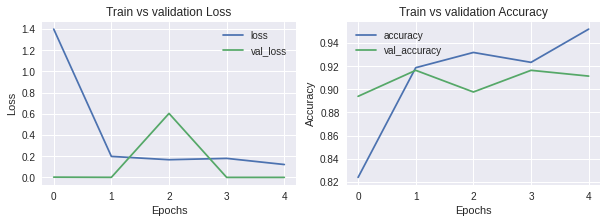

In [39]:
# VGG16 Validation Curves
print("******************** VGG16 Curves ********************")
plot_validation_curves(model_vgg.history.history)

******************** ResNet50V2 Curves ********************


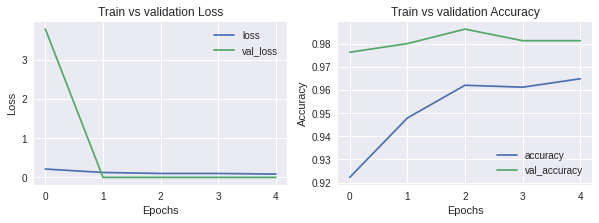

In [61]:
# ResNet50V2 Validation Curves
print("******************** ResNet50V2 Curves ********************")
plot_validation_curves(model_resnet.history.history)

******************** MobileNet_V2 Curves ********************


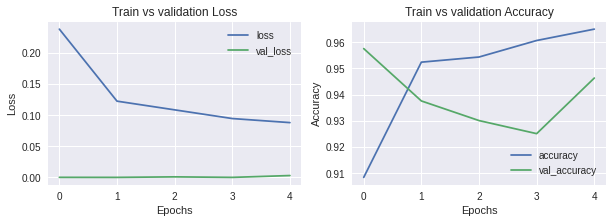

In [67]:
# MobileNet_V2 Validation Curves
print("******************** MobileNet_V2 Curves ********************")
plot_validation_curves(model_mobnet.history.history)

******************** InceptionV3 Curves ********************


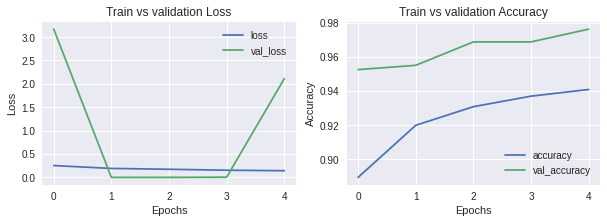

In [73]:
# InceptionV3 Validation Curves
print("******************** InceptionV3 Curves ********************")
plot_validation_curves(model_incepv3.history.history)

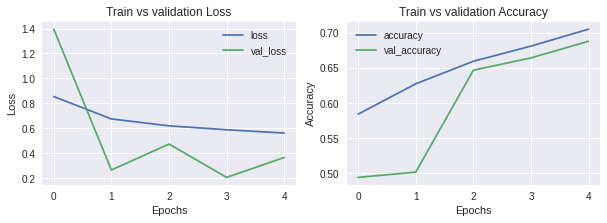

In [26]:
# Custom Model Validation Curves
plot_validation_curves(model_cus.history.history)

## **b) Performing prediction on unseen data**

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

def plot_summary(pred_prob):
  '''
  Plots confustion matrix and classification report.
  '''
  # Selecting class based on higher probabilities
  y_pred_classes = np.argmax(pred_prob,axis=1)
  # Reverting one-hot encoding on true validation output labels
  y_test_classes = np.argmax(y_test,axis=1)
  print("***************** CLASSIFICATION REPORT *****************")
  print(classification_report(y_test_classes,y_pred_classes),"\n\n")
  print("******************* CONFUSION MATRIX *******************")
  plt.figure(figsize=(8,8))
  sns.heatmap(confusion_matrix(y_test_classes,y_pred_classes),linewidths=.5,cmap="YlGnBu",annot=True,cbar=False,fmt='d')
  plt.show()

In [29]:
test_generator = test_datagen.flow(
      x=X_test,
      y=y_test,
      batch_size=1,
      shuffle=False,
  )
nb_samples = len(X_test)

**Performing predictions on VGG16 based model**

***************** CLASSIFICATION REPORT *****************
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1011
           1       0.88      0.97      0.92      1012

    accuracy                           0.92      2023
   macro avg       0.92      0.92      0.92      2023
weighted avg       0.92      0.92      0.92      2023
 


******************* CONFUSION MATRIX *******************


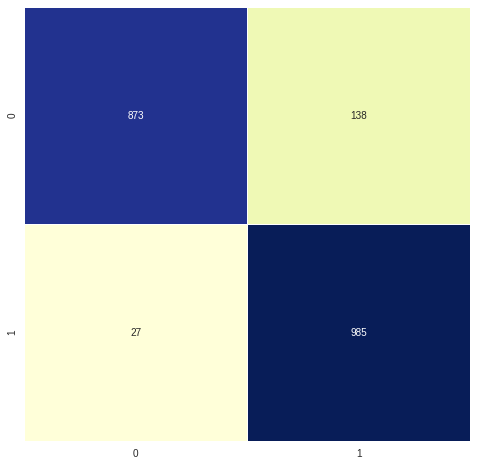

In [42]:
# Returns probabilities for each classes
pred_prob = model_vgg.predict_generator(test_generator, steps = nb_samples)
plot_summary(pred_prob)

**Performing predictions on ResNet50_v2 based model**

***************** CLASSIFICATION REPORT *****************
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1011
           1       0.99      0.97      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023
 


******************* CONFUSION MATRIX *******************


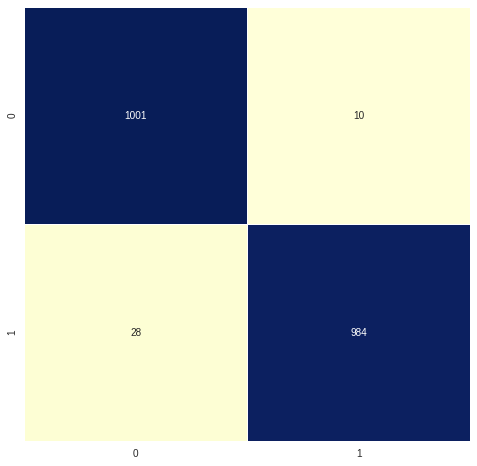

In [62]:
# Returns probabilities for each classes
pred_prob = model_resnet.predict_generator(test_generator, steps = nb_samples)
plot_summary(pred_prob)

**Performing predictions on MobileNet_v2 based model**

***************** CLASSIFICATION REPORT *****************
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1011
           1       1.00      0.91      0.95      1012

    accuracy                           0.95      2023
   macro avg       0.96      0.95      0.95      2023
weighted avg       0.96      0.95      0.95      2023
 


******************* CONFUSION MATRIX *******************


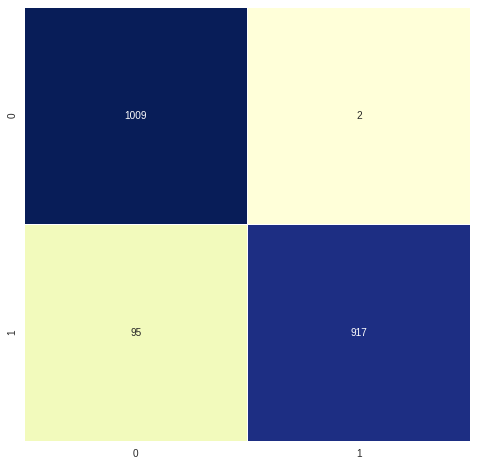

In [68]:
# Returns probabilities for each classes
pred_prob = model_mobnet.predict_generator(test_generator, steps = nb_samples)
plot_summary(pred_prob)

**Performing predictions on InceptionV3 based model**

***************** CLASSIFICATION REPORT *****************
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1011
           1       1.00      0.96      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023
 


******************* CONFUSION MATRIX *******************


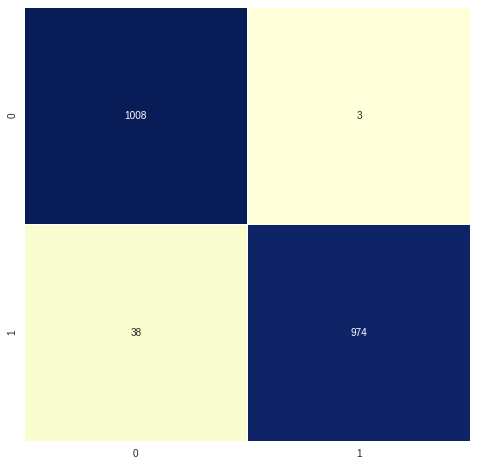

In [74]:
# Returns probabilities for each classes
pred_prob = model_incepv3.predict_generator(test_generator, steps = nb_samples)
plot_summary(pred_prob)

**Performing predictions on Custom model**

***************** CLASSIFICATION REPORT *****************
              precision    recall  f1-score   support

           0       0.67      0.77      0.71      1011
           1       0.73      0.62      0.67      1012

    accuracy                           0.69      2023
   macro avg       0.70      0.69      0.69      2023
weighted avg       0.70      0.69      0.69      2023
 


******************* CONFUSION MATRIX *******************


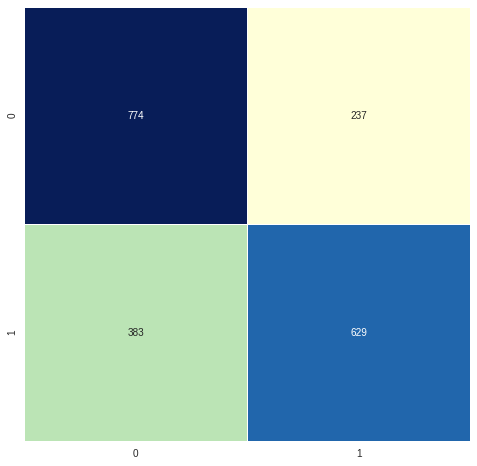

In [30]:
# Returns probabilities for each classes
pred_prob = model_cus.predict_generator(test_generator, steps = nb_samples)
plot_summary(pred_prob)